<img src="IMG/logo_UNSAM.jpg" align="right" width="150" /> 

#### Análisis y Procesamiento de Señales - Segundo Cuatrimestre 2025

# Trabajo Práctico Nº3: Análisis de Fourier: FFT, desparramo, interpolación y ventaneo
#### Matías Cassino

# Consignas

En esta tarea semanal analizaremos un fenómeno muy particular que se da al calcular la DFT, el efecto de desparramo espectral.  

Luego, haremos el siguiente experimento:

   - Senoidal de frecuencia f0=k0∗fS/N=k0.Δf
   - Potencia normalizada, es decir energía (o varianza) unitaria

1. Se pide:

    Sea k0
 
    - N4
 
    - N4+0.25
 
    - N4+0.5
 
Notar que a cada senoidal se le agrega una pequeña desintonía respecto a  Δf.

A) Graficar las tres densidades espectrales de potencia (PDS's) y discutir cuál es el efecto de dicha desintonía en el espectro visualizado.

B) Verificar la potencia unitaria de cada PSD, puede usar la identidad de Parseval. 
En base a la teoría estudiada. Discuta la razón por la cual una señal senoidal tiene un espectro tan diferente respecto a otra de muy pocos Hertz de diferencia. 

C) Repetir el experimento mediante la técnica de zero padding. Dicha técnica consiste en agregar ceros al final de la señal para aumentar Δf de forma ficticia. Probar agregando un vector de 9*N ceros al final. Discuta los resultados obtenidos.

Bonus

2. Calcule la respuesta en frecuencia de los sistemas LTI de la TS2.

# Introducción

Inicialmente, en este trabajo se estudió el desparramo espectral a través de frecuencias equivalentes a múltiplos enteros y no enteros de la resolución espectral (Δf) para señales senoidales.
Posteriormente, en cada caso se verificó la conservación de la energía a través de la identidad de Parseval. Además, se aplicó la técnica de zero padding para mejorar artificialmente la resolución espectral y así observar con mayor definición la interpolación de la señal de entrada y sus características.
Por último, se calculó la respuesta en frecuencia y determinó el tipo de estabilidad de diversos sistemas LTI en función de sus respuestas al impulso y el análisis de polos y ceros.

# Desarrollo experimental

In [1]:
#%% Modulos
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pdsmodulos as pds
from scipy import signal

#%% Funciones
plt.close("all")

# Senoidal
def mi_funcion_sen(vmax, dc, ff, ph, N, fs, plot=True):
    
    # Datos generales de la simulación
    ts = 1/fs # tiempo de muestreo
    tt = np.linspace(0, (N-1)*ts, N).flatten() # grilla de sampleo temporal
    arg = 2*np.pi*ff*tt + ph # argumento
    xx = (vmax*(np.sin(arg)) + dc).flatten() # señal
    pot = (1/N)*np.sum(xx**2)
    
    if plot:
        
        #Presentación gráfica de los resultados
        plt.figure()
        plt.plot(tt, xx, label=f"f = {ff} Hz\nN = {N}\nTs = {ts} s\nPotencia = {pot:.3f} W")
        plt.title('Señal: senoidal')
        plt.xlabel('tiempo [s]')
        plt.ylabel('Amplitud [V]')
        plt.grid()
        plt.xlim([tt.min() - 0.1*(tt.max()-tt.min()), tt.max() + 0.1*(tt.max()-tt.min())])
        plt.ylim([xx.min() - 0.1*(xx.max()-xx.min()), xx.max() + 0.1*(xx.max()-xx.min())])
        plt.legend()
        plt.show() 
        
    return tt,xx

def normalizacion(x):
    media_x=np.mean(x) #media
    desvio_x=np.std(x) #desvio
    xx_norm=(x-media_x)/desvio_x #señal normalizada
    varianza_x=np.var(xx_norm) #varianza
    
    return xx_norm,varianza_x

def densidad_potencia(x):
    densidad_pot_x=fft_abs_func(x)**2 # Densidad de potencia
    
    return densidad_pot_x

def parseval(x,densidad_potencia_x,N):
    energia_t_x=np.sum(np.abs(x)**2)/N
    potencia_f_x=(1/N**2)*np.sum(densidad_potencia_x)
    
    if np.isclose(energia_t_x, potencia_f_x, rtol=1e-6):  # comparación con tolerancia numérica
        print(f"Se cumple la identidad de Parseval: Energía = {energia_t_x:.4f} = Densidad espectral de potencia = {potencia_f_x:.4f}")
    else:
        print(f"No se cumple la identidad de Parseval: Energía = {energia_t_x:.4f} != Densidad espectral de potencia = {potencia_f_x:.4f}")
        
        
    return energia_t_x,potencia_f_x

def zero_padding_fft_abs(M,N,x_norm):
    x_zp=np.zeros(M)
    x_zp[0:N]=x_norm
    
    return x_zp

def ec_diferencias_coef(coef_x,coef_y,N,fs,señal, title,y_label="y",plot=True):
    
    # Salida del sistema
    y = signal.lfilter(coef_x, coef_y, señal)
    n = np.arange(N)
    t_simulacion=N*(1/fs)
    pot = (1/N)*np.sum(y**2)
    
    if plot: 
        plt.figure()
        plt.plot(n, y,'--x',label  = f"fs = {fs} Hz\nTiempo de simulación = {t_simulacion:.3f} s\nPotencia de {y_label}[n]= {pot:.3g} W")
        plt.title(title +' por lfilter')
        plt.xlabel("n")
        plt.ylabel(y_label + "[n]")
        plt.xlim([n.min() - 0.1*(n.max()-n.min()), n.max() + 0.1*(n.max()-n.min())])
        plt.ylim([y.min() - 0.1*(y.max()-y.min()), y.max() + 0.1*(y.max()-y.min())])
        plt.legend()
        plt.grid()
        plt.show()
      
    return y
    
def fft_abs_func(x):
    fft_x=np.fft.fft(x) # FFT
    fft_x_abs=np.abs(fft_x) # Módulo de la FFT
    
    return fft_x_abs

#%% Parámetros
# Punto 1
N=1000
fs=1000
df=fs/N
k=np.arange(N)*df
k0_1=N/4
k0_2=(N/4)+0.25
k0_3=(N/4)+0.5
M=10*N
k_M=np.arange(M)*df

# Bonus (punto 2)
# Sistema 1
coef_x_I= [0.03, 0.05, 0.03]
coef_y_I= [1, -1.5, 0.5]
# Sistema 2
coef_x_II= [1] + [0]*9 + [3]
coef_y_II= [1]
# Sistema 3
coef_x_III= [1]
coef_y_III= [1] + [0]*9 + [-3]

# Análisis de resultados

1.A) 

In [2]:
#%% Invocación de las funciones del punto 1.A
tt_1,xx_1 = mi_funcion_sen(vmax = 1, dc = 0, ff = k0_1*df, ph=0, N=N,fs=fs,plot=None)
tt_2,xx_2 = mi_funcion_sen(vmax = 1, dc = 0, ff = k0_2*df, ph=0, N=N,fs=fs,plot=None)
tt_3,xx_3 = mi_funcion_sen(vmax = 1, dc = 0, ff = k0_3*df, ph=0, N=N,fs=fs,plot=None)

# Normalización de la señal
xx_1_norm,varianza_1=normalizacion(xx_1)
xx_2_norm,varianza_2=normalizacion(xx_2)
xx_3_norm,varianza_3=normalizacion(xx_3)

# Densidad de potencia
densidad_pot_1=densidad_potencia(xx_1_norm) 
densidad_pot_2=densidad_potencia(xx_2_norm) 
densidad_pot_3=densidad_potencia(xx_3_norm) 

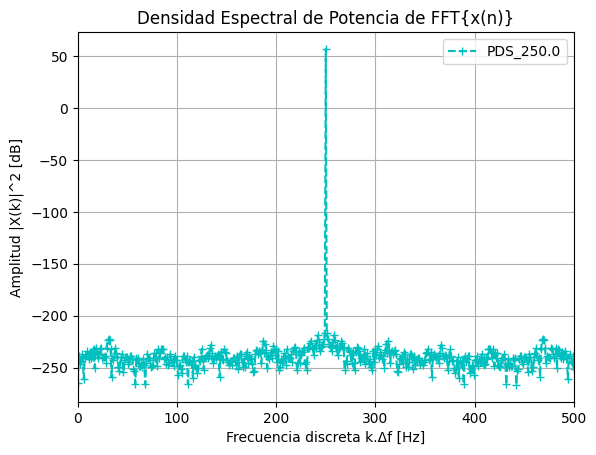

In [3]:
# Presentación gráfica de los resultados para K0_1
plt.figure()
plt.plot(k,10*np.log10(densidad_pot_1),'c--+',label=f'PDS_{k0_1*df}')
plt.title('Densidad Espectral de Potencia de FFT{x(n)}')
plt.xlabel('Frecuencia discreta k.Δf [Hz]')
plt.ylabel('Amplitud |X(k)|^2 [dB]')
plt.grid()
plt.legend()
plt.xlim([0, fs/2]) 
plt.show() 

- El gráfico presenta la potencia concentrada fundamentalmente en una frecuencia, la cual se corresponde a la delta centrada en 250 Hz que deriva de aplicar la FFT a una función senoidal y presentar únicamente la mitad del espectro en módulo. Al graficarse en la escala de los decibelios se aprecian múltiples valores con módulo previamente insignificante dado su cercanía al cero, los cuales resultan del ruido numérico y se exhiben al aumentar el rango dinámico.

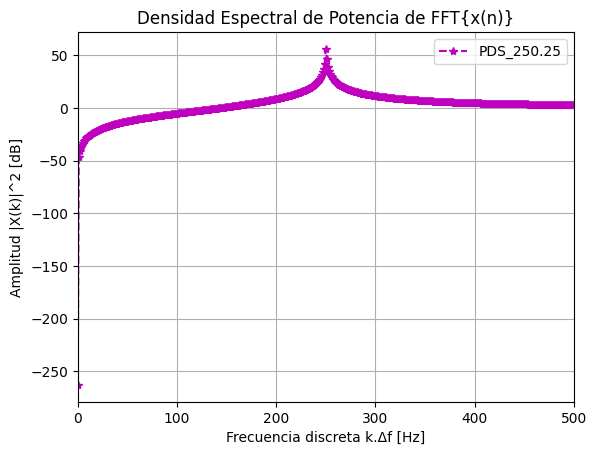

In [4]:
# Presentación gráfica de los resultados para K0_2
plt.figure()
plt.plot(k,10*np.log10(densidad_pot_2),'m--*',label=f'PDS_{k0_2*df}')
plt.title('Densidad Espectral de Potencia de FFT{x(n)}')
plt.xlabel('Frecuencia discreta k.Δf [Hz]')
plt.ylabel('Amplitud |X(k)|^2 [dB]')
plt.grid()
plt.legend()
plt.xlim([0, fs/2]) 
plt.show() 

- Se exhibe un desparramo espectral de la energía en todo el ancho de banda dado que la frecuencia de la señal $ f=250.25 $ no coincide con uno de los múltiplos enteros de la frecuencia discreta determinados por $ k.Δf $, por ende, hay un conjunto de deltas con magnitud significativa a diferencia del gráfico anterior que poseía un único delta. Además, el máximo se desplaza al valor entero discreto de frecuencia más próximo y el desparamo es asimétrico porque favorece la distribución hacia el lado más próximo por el que se acerque el valor no entero hacia el máximo, es decir, la derecha. Con respecto a esto último, si la frecuencia de la señal fuera de 250.75, el gráfico resultante sería un reflejo invertido donde la energía sería mayor a izquierda y decrecería más vertiginosamente a la derecha.

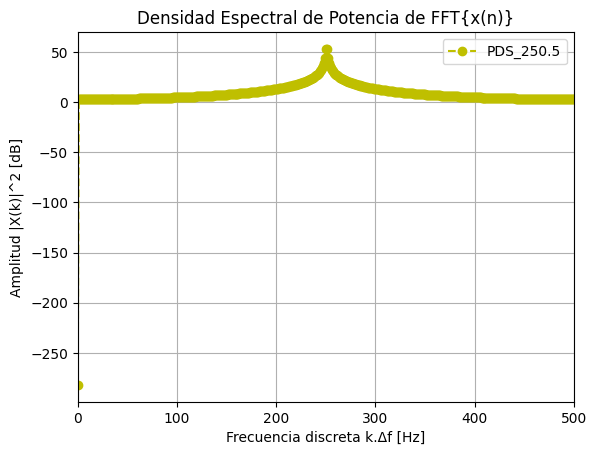

In [5]:
# Presentación gráfica de los resultados para K0_3
plt.figure()
plt.plot(k,10*np.log10(densidad_pot_3),'y--o',label=f'PDS_{k0_3*df}')
plt.title('Densidad Espectral de Potencia de FFT{x(n)}')
plt.xlabel('Frecuencia discreta k.Δf [Hz]')
plt.ylabel('Amplitud |X(k)|^2 [dB]')
plt.grid()
plt.legend()
plt.xlim([0, fs/2]) 
plt.show() 

- En este caso, también hay un desparramo espectral debido a las razones previamente mencionadas pero con la consideración de que la distribución es simétrica a razón de que los extremos máximos son dos en lugar de uno, por lo tanto, se ve unpatrón equilibrado hacia izquierda y derecha de los valores de frecuencia discreta 250 y 251 respectivamente.

1.B 

In [6]:
#%% Invocación de las funciones del punto 1.B
# Verifico Parseval
energia_t_1,potencia_f_1=parseval(xx_1_norm,densidad_pot_1,N)
energia_t_2,potencia_f_2=parseval(xx_2_norm,densidad_pot_2,N)
energia_t_3,potencia_f_3=parseval(xx_3_norm,densidad_pot_3,N)

Se cumple la identidad de Parseval: Energía = 1.0000 = Densidad espectral de potencia = 1.0000
Se cumple la identidad de Parseval: Energía = 1.0000 = Densidad espectral de potencia = 1.0000
Se cumple la identidad de Parseval: Energía = 1.0000 = Densidad espectral de potencia = 1.0000


- Luego de normalizar por el número de muestras y considerar el error numérico dentro de la función, se verifica la identidad de Parseval de valor unitario entre la potencia en el dominio de la frecuencia y la energía en el dominio del tiempo dada por la relación

  $$ \sum_{n=0}^{N-1}|x[n]|^2=\frac{1}{N}.\sum_{k=0}^{N-1}|X[k]|^2$$

  En adición, la razón por la cual una señal senoidal tiene un espectro tan diferente respecto a otra de muy pocos Hertz de diferencia se debe al fenómeno del desparramo espectral como consecuencia de que la frecuencia de la señal no coincide con la grilla de frecuencias discretas, por lo tanto, la energía no se concentra en un solo valor y se representa con uno o dos máximos, según si el desparramo es asimétrico o simétrico, en conjunto a valores de menor magnitud que pueden tener una tendencia creciente y decreciente o idéntica de ambos lados de el/los extremo/os respectivamente. Por su parte, cuando la frecuencia coincide con un múltiplo de la resolución espectral, esto se expone como una delta desplaza a tal frecuencia que concentra toda la energía junto con ruido numérico de módulo despreciable. También, tal fenómeno implica un achatamiento de las amplitudes y, en efecto, se escala a decibelios.

1.C)  Inicialmente, se debe hacer hincapié en que al digitalizar una señal que completa un período con M muestras asumiendo una cantidad de muestras N, donde M>N, se fuerza la periodicidad. Esto puede prevenirse mediante la técnica zero padding que consiste en agregar ceros a la señal a fin de incrementar la cantidad de puntos con los que se interpola el espectro al aplicar la FFT y "mejorar" artificialmente la resolución espectral, es decir, no cambia la información sino la grilla de frecuencias desde la perspectiva de la ventana. Asímismo, la determinación de un número de muestras N conlleva el producto entre una ventana rectangular implícita de longitud N y la señal en el dominio del tiempo discreto, lo cual al transformarse al dominio de la frecuencia discreta resulta en la convolución circular de la señal por una sinc. Entonces, el zero padding contribuye a muestrear mejor la sinc interpolante y brindar suavidad.

In [7]:
#%% Invocación de las funciones del punto 1.C
xx_1_zp=zero_padding_fft_abs(M,N,xx_1_norm)
xx_2_zp=zero_padding_fft_abs(M,N,xx_2_norm)
xx_3_zp=zero_padding_fft_abs(M,N,xx_3_norm)

# Densidad de potencia de las señales con zero padding
densidad_pot_1_zp=densidad_potencia(xx_1_zp) 
densidad_pot_2_zp=densidad_potencia(xx_2_zp) 
densidad_pot_3_zp=densidad_potencia(xx_3_zp)

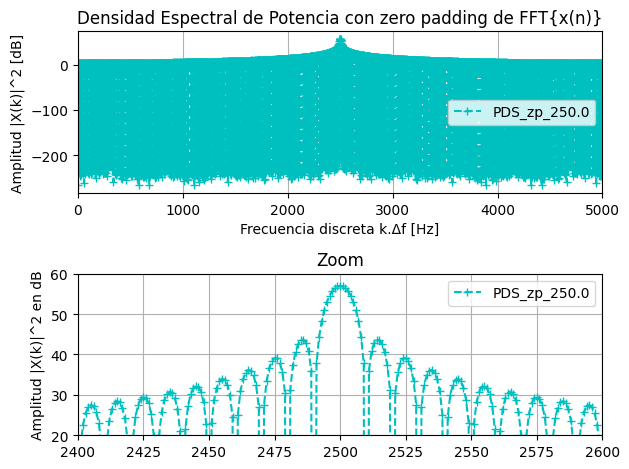

In [8]:
# Presentación gráfica de los resultados de zero padding para K0_1
plt.figure()

plt.subplot(2,1,1)
plt.plot(k_M,10*np.log10(densidad_pot_1_zp),'c--+',label=f'PDS_zp_{k0_1*df}')
plt.title('Densidad Espectral de Potencia con zero padding de FFT{x(n)}')
plt.xlabel('Frecuencia discreta k.Δf [Hz]')
plt.ylabel('Amplitud |X(k)|^2 [dB]')
plt.grid()
plt.legend()
plt.xlim([0, M/2]) 

plt.subplot(2,1,2)
plt.plot(k_M,10*np.log10(densidad_pot_1_zp),'c--+',label=f'PDS_zp_{k0_1*df}')
plt.title('Zoom')
plt.ylabel('Amplitud |X(k)|^2 en dB')
plt.grid()
plt.legend()
plt.ylim([20,60])
plt.xlim([2400, 2600]) 

plt.tight_layout()
plt.show() 

- Al aplicar la técnica de zero padding y realizar un zoom, se observa un espectro interpolado por una sinc centrada en la frecuencia 250 escalada un orden de magnitud que posee una amplia cantidad de valores de amplitud significativa entre los valores correspondientes a la grilla de frecuencias del gráfico expuesto en el punto 1A sin emplear dicho método.
  

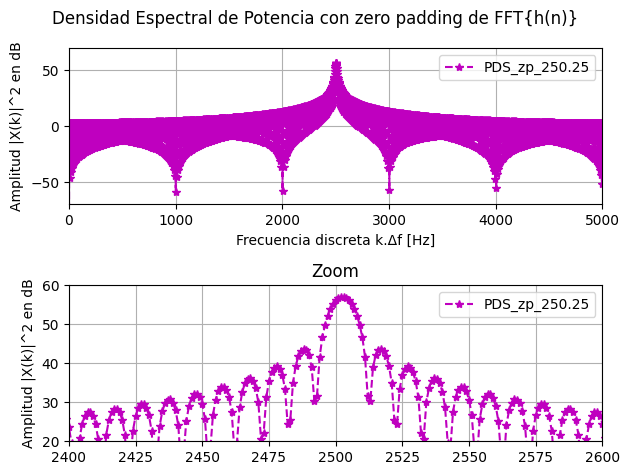

In [9]:
# Presentación gráfica de los resultados de zero padding para K0_2
plt.figure()
plt.suptitle('Densidad Espectral de Potencia con zero padding de FFT{h(n)}')

plt.subplot(2,1,1)
plt.plot(k_M,10*np.log10(densidad_pot_2_zp),'m--*',label=f'PDS_zp_{k0_2*df}')
plt.xlabel('Frecuencia discreta k.Δf [Hz]')
plt.ylabel('Amplitud |X(k)|^2 en dB')
plt.grid()
plt.legend()
plt.xlim([0, M/2])
plt.ylim([-70, 70]) 

plt.subplot(2,1,2)
plt.plot(k_M,10*np.log10(densidad_pot_2_zp),'m--*',label=f'PDS_zp_{k0_2*df}')
plt.title('Zoom')
plt.ylabel('Amplitud |X(k)|^2 en dB')
plt.grid()
plt.legend()
plt.ylim([20,60])
plt.xlim([2400, 2600]) 

plt.tight_layout()
plt.show() 

- Para este caso donde la frecuencia de la señal no se corresponde con un múltiplo entero de la resolución espectral, la sinc se centra en el valor N/4 + 0.25 escalado dada la invarianza de la delta ante la convolución. Simultáneamente, la sinc se desplaza respecto a la grilla de frecuencias debido al factor 0.25, por lo tanto, la interpolación de los valores $k.Δf$ resulta asimétrica al distribuir sus ceros entre muestras no pertenecientes a la grilla.
  También, algunos lóbulos acentúan sus mínimos en comparación al espectro sin zero padding a efectos de lo previamente descripto.

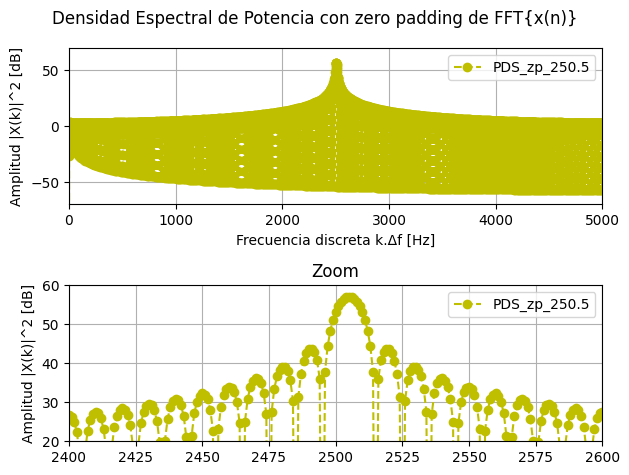

In [10]:
# Presentación gráfica de los resultados de zero padding para K0_3
plt.figure()
plt.suptitle('Densidad Espectral de Potencia con zero padding de FFT{x(n)}')

plt.subplot(2,1,1)
plt.plot(k_M,10*np.log10(densidad_pot_3_zp),'y--o',label=f'PDS_zp_{k0_3*df}')
plt.xlabel('Frecuencia discreta k.Δf [Hz]')
plt.ylabel('Amplitud |X(k)|^2 [dB]')
plt.grid()
plt.legend()
plt.xlim([0, M/2])
plt.ylim([-70,70])

plt.subplot(2,1,2)
plt.plot(k_M,10*np.log10(densidad_pot_3_zp),'y--o',label=f'PDS_zp_{k0_3*df}')
plt.title('Zoom')
plt.ylabel('Amplitud |X(k)|^2 [dB]')
plt.grid()
plt.legend()
plt.ylim([20, 60])
plt.xlim([2400,2600])

plt.tight_layout()
plt.show() 

- Por su parte, cuando la frecuencia de la señal corresponde a 250.5 y se aplica zero padding previo a emplear la FFT, se observa una sinc centrada en dicho valor escalado por 10 que interpola la senoidal a mitad de cada valor entero de la grilla de frecuencias, lo cual deriva en un reparto simétrico de energía.
  Cabe enfatizar que la asimetría que se evidencia al lado izquierdo del extremo es causada por la amplificación de diferencias pequeñas de punto flotante en la escada dB.

In [11]:
# Verifico Parseval
energia_t_1_zp,potencia_f_1_zp=parseval(xx_1_zp,densidad_pot_1_zp,M)
energia_t_2_zp,potencia_f_2_zp=parseval(xx_2_zp,densidad_pot_2_zp,M)
energia_t_3_zp,potencia_f_3_zp=parseval(xx_3_zp,densidad_pot_3_zp,M)

Se cumple la identidad de Parseval: Energía = 0.1000 = Densidad espectral de potencia = 0.1000
Se cumple la identidad de Parseval: Energía = 0.1000 = Densidad espectral de potencia = 0.1000
Se cumple la identidad de Parseval: Energía = 0.1000 = Densidad espectral de potencia = 0.1000


- A partir de la función desarrollada, se verifica la identidad de Parseval. Sin embargo, el valor de potencia no es unitaria ya que se está considerando en las sumatorias M valores donde en realidad solo N son no nulos, y esto deriva en un factor N/M. En efecto, el zero padding no altera la relación entre la energía y la potencia sino que incide en la normalización.

Bonus (punto 2). Inicialmente, se aplica la FFT sobre la respuesta al impulso de cada sistema. Possteriormente, se pondera el análisis de polos y ceros en la circunferencia unitaria del plano complejo para definir la estabilidad. 

Los polos del sitema I son: [1.  0.5]

Los ceros del sitema I son: [-0.83333333+0.5527708j -0.83333333-0.5527708j]

Los polos del sitema II son: []

Los ceros del sitema II son: [-1.06149622e+00+0.34490103j -1.06149622e+00-0.34490103j
 -6.56040741e-01+0.90296262j -6.56040741e-01-0.90296262j
  5.55111512e-16+1.11612317j  5.55111512e-16-1.11612317j
  6.56040741e-01+0.90296262j  6.56040741e-01-0.90296262j
  1.06149622e+00+0.34490103j  1.06149622e+00-0.34490103j]

Los polos del sitema III son: [-1.11612317+0.j         -0.90296262+0.65604074j -0.90296262-0.65604074j
 -0.34490103+1.06149622j -0.34490103-1.06149622j  0.34490103+1.06149622j
  0.34490103-1.06149622j  1.11612317+0.j          0.90296262+0.65604074j
  0.90296262-0.65604074j]

Los ceros del sitema III son: []



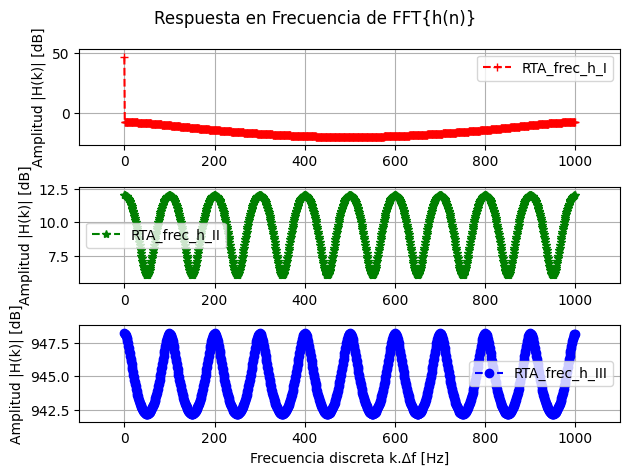

In [15]:
#%% Invocación de la función del Bonus (punto 2)
delta_aux=signal.unit_impulse(N)

h_I=ec_diferencias_coef(coef_x_I,coef_y_I,N,fs,delta_aux,y_label="h",title="Respuesta al impulso del sistema I LTI",plot=None)
h_II=ec_diferencias_coef(coef_x_II,coef_y_II,N,fs,delta_aux,y_label="h",title="Respuesta al impulso del sistema II LTI",plot=None)
h_III=ec_diferencias_coef(coef_x_III,coef_y_III,M,fs,delta_aux,y_label="h",title="Respuesta al impulso del sistema III LTI",plot=None)

fft_abs_h_I=fft_abs_func(h_I)
fft_abs_h_II=fft_abs_func(h_II)
fft_abs_h_III=fft_abs_func(h_III)

fft_abs_h_I_db=20*np.log10(fft_abs_h_I)
fft_abs_h_II_db=20*np.log10(fft_abs_h_II)
fft_abs_h_III_db=20*np.log10(fft_abs_h_III)

polos_I = np.roots(coef_y_I)
ceros_I = np.roots(coef_x_I)
polos_II = np.roots(coef_y_II)
ceros_II = np.roots(coef_x_II)
polos_III = np.roots(coef_y_III)
ceros_III = np.roots(coef_x_III)

print(f'Los polos del sitema I son: {polos_I}\n')
print(f'Los ceros del sitema I son: {ceros_I}\n')
print(f'Los polos del sitema II son: {polos_II}\n')
print(f'Los ceros del sitema II son: {ceros_II}\n')
print(f'Los polos del sitema III son: {polos_III}\n')
print(f'Los ceros del sitema III son: {ceros_III}\n')

plt.figure()
plt.suptitle('Respuesta en Frecuencia de FFT{h(n)}')

plt.subplot(3,1,1)
plt.plot(k,fft_abs_h_I_db,'r--+',label='RTA_frec_h_I')
plt.ylabel('Amplitud |H(k)| [dB]')
plt.xlim([k.min() - 0.1*(k.max()-k.min()), k.max() + 0.1*(k.max()-k.min())])
plt.ylim([fft_abs_h_I_db.min() - 0.1*(fft_abs_h_I_db.max()-fft_abs_h_I_db.min()), fft_abs_h_I_db.max() + 0.1*(fft_abs_h_I_db.max()-fft_abs_h_I_db.min())])
plt.grid()
plt.legend()

plt.subplot(3,1,2)
plt.plot(k,fft_abs_h_II_db,'g--*',label='RTA_frec_h_II')
plt.ylabel('Amplitud |H(k)| [dB]')
plt.xlim([k.min() - 0.1*(k.max()-k.min()), k.max() + 0.1*(k.max()-k.min())])
plt.ylim([fft_abs_h_II_db.min() - 0.1*(fft_abs_h_II_db.max()-fft_abs_h_II_db.min()), fft_abs_h_II_db.max() + 0.1*(fft_abs_h_II_db.max()-fft_abs_h_II_db.min())])
plt.grid()
plt.legend()

plt.subplot(3,1,3)
plt.plot(k,fft_abs_h_III_db,'b--o',label='RTA_frec_h_III')
plt.xlabel('Frecuencia discreta k.Δf [Hz]')
plt.ylabel('Amplitud |H(k)| [dB]')
plt.xlim([k.min() - 0.1*(k.max()-k.min()), k.max() + 0.1*(k.max()-k.min())])
plt.ylim([fft_abs_h_III_db.min() - 0.1*(fft_abs_h_III_db.max()-fft_abs_h_III_db.min()), fft_abs_h_III_db.max() + 0.1*(fft_abs_h_III_db.max()-fft_abs_h_III_db.min())])
plt.grid()
plt.legend()

plt.tight_layout()
plt.show() 

- I) Posee un polo dentro del círculo de módulo unitario y otro sobre el mismo, por lo tanto, el sistema es marginalmente estable (no diverge ni decae). Además, se observa una atenuación rápida luego de alcanzar un máximo, y esto verifica que su respuesta al impulso tienda a un valor constante luego de incrementar vertiginosamente.
  
- II) El sistema no posee polos, por ende, el sistema es estable. Paralelamente, hay 5 pares de raíces complejas que definen el patrón de oscilaciones periódicas. Esto se refleja en la tendencia a cero de la respuesta al impulso del TS2 al tender n a infinito.

  
- III) Este tiene polos de módulo mayor 1, es decir, el sistema es inestable y su respuesta a impulso crece sin límite, pero esto no es posible de representar ya que se obtiene valores de tipo NaN si se extiende la cantidad de muestras.

Cabe destacar que los sistemas II y III tienen gráficos semejantes debido a sus retardos. Sin embargo, este último evidencia su inestabilidad a través de la agudeza y magnitud de sus picos que teóricamente son infinitos en contraposición a las senoidales del II que son más suaves, lo cual también está determinado por la presencia de ceros.

# Conclusiones
Finalmente, se deduce que al calcular la FFT de senoidales con frecuencias como múltiplos enteros de la resolución espectral, estas se sincronizan con la grilla de frecuencias y el espectro presenta una delta, si se observa hasta Nyquist, que concentra toda la energía localizada en dicha frecuencia. No obstante, si la frecuencia difiere de un número entero, se produce una desincronización y el efecto de desparramo espectral, el cual consiste en una distribución de la energía en todas las frecuencias. Tal distribución puede ser simétrica o asimétrica al lado derecho e izquierdo de la frecuencia entera más próxima, que resulta máxima, según la desintonía. 
De este modo, a pesar de que ciertas señales tengan frecuencias similares, sus espectros son completamente diferentes.

También, se constató la identidad de Parseval tanto sin como con zero padding, lo cual derivó en que la energía permanezca constante. Además, se debe hacer hincapié en que al aplicar dicha técnica la normalización de la potencia varía ya que se aumenta el número de muestras y, por tal motivo, no se obtiene un valor unitario.

En adición, la técnica de zero padding permitió extender la señal con ceros y mejorar la suavidad de la interpoación de la señal de entrada transformada por la FFT mediante la sinc. En consecuencia, se analizó con mayor detalle el desparramo en los lóbulos sin adherir información.

Por su parte, el estudio de la respuesta en frecuencia de los sistemas LTI por medio del empleo de la FFT sobre la respuesta al impulso se asoció a su tipo estabilidad por medio de la obtención de polos y ceros.

# Autoevaluación
A)Resolví la terea con seguridad.

B) Lo aprendido en esta tarea fue la capacidad de determinar los efectos sobre el espectro según la frecuencia de la señal seleccionada respecto a la grilla de frecuencias discretas, la utilidad de la técnica de zero padding para así mejorar la interpolación de la transformada de la señal y favorecer su estudio detallado sin alterar la energía, y el vínculo entre las propiedades de estabilidad de un sistema LTI y la posición de sus polos y ceros, lo cual se refleja en la respuesta en frecuencia.

C) No fue usada.